In [1]:
import sys
sys.path.append('/home/axf295/2019/code/spt3g_software/build/')
from spt3g import core, std_processing
from matplotlib import pylab as pl
import numpy as np
import glob

source = 'CenA'

data_loc = '/spt/user/production/calibration/%s-pixelraster/coaddmaps/'%source
data_files = glob.glob(data_loc+'7*')

#goodobs = ['64610968'] #'64153936','65758434',


In [2]:
obsIDs = []

for file in data_files:
    obs = file.split('/')[-1].split('.')[0]
    if int(obs) <76069964:
        obsIDs.append(obs)
        print(obs)

72096094
73240056
74915420
70271423
73773950
75495737
70834548
71429632
74346161
72666212


In [5]:
sys.path.append('/home/axf295/2019/code/spt3g_software/polcal/python/')
import CenA_Map_Utils as CMU
import General_Utils as GU


Coadd = {}
Weight = {}
pixelvals = {}

noise_mask = {}


for obs in obsIDs:
    file = data_loc+obs+'.g3'
    data = core.G3File(file)
    while True:
        try:
            fr = data.next()
            if 'Wpol' in fr:
                band = fr['Id']
                if band not in Coadd:
                    Coadd[band] = {}
                    pixelvals[band] = {}
                if band not in noise_mask:
                    noise_mask[band] = 1.-np.loadtxt('/home/axf295/2019/code/%s/Masks/0p25arcmin/%s_Amp_Mask.txt'%(source,band.split('-')[1]))
                obsmap = CMU.CenAMap(fr,has_pol = True)
                obsmap.get_brightest_pixel()
                obsmap.center_map()
                obsmap.interpolate_map_nans()
                
                mapvar = CMU.calc_source_masked_variance(np.asarray(obsmap.maps['T']),noise_mask[band])
                obsmap.noise = mapvar
                if not np.isfinite(mapvar) or mapvar == 0.:
                    continue
                weights = 1./mapvar
                
                if band not in Weight:
                    Weight[band] = weights
                else:
                    Weight[band] += np.copy(weights)
                '''
                pl.figure(figsize=(15,5))
                pl.subplot(131)
                pl.imshow(obsmap.maps['T']);pl.colorbar()
                pl.grid(color='w')
                pl.subplot(132)
                pl.imshow(obsmap.maps['Q']);pl.colorbar()
                pl.subplot(133)
                pl.imshow(obsmap.maps['U']);pl.colorbar()
                pl.suptitle('%s, %sGhz'%(obs,band))
                pl.savefig('/big_scratch/axf295/2019/CenA/Analyzed_Data/%s/%s_%sGHz_TQU_coaddmaps.png'%(obs,obs,band))
                pl.close('all')
                '''
                try:    
                    if 'T' not in Coadd[band]:
                        Coadd[band]['T'] = obsmap.maps['T']*weights
                        Coadd[band]['Q'] = obsmap.maps['Q']*weights
                        Coadd[band]['U'] = obsmap.maps['U']*weights
                    else:
                        Coadd[band]['T'] += obsmap.maps['T']*weights
                        Coadd[band]['Q'] += obsmap.maps['Q']*weights
                        Coadd[band]['U'] += obsmap.maps['U']*weights
                except ValueError:
                    print('Map size for %s not proper'%obs)
                    continue
        except StopIteration:
            break
                                

/home/axf295/2019/code/spt3g_software/polcal/python/CenA_Map_Utils.py:355: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Noise_Mask == '':


32
40
CenA-90GHz MaxPolAmp: 12 mK
32
40
CenA-150GHz MaxPolAmp: 6 mK
32
40
CenA-220GHz MaxPolAmp: 15 mK


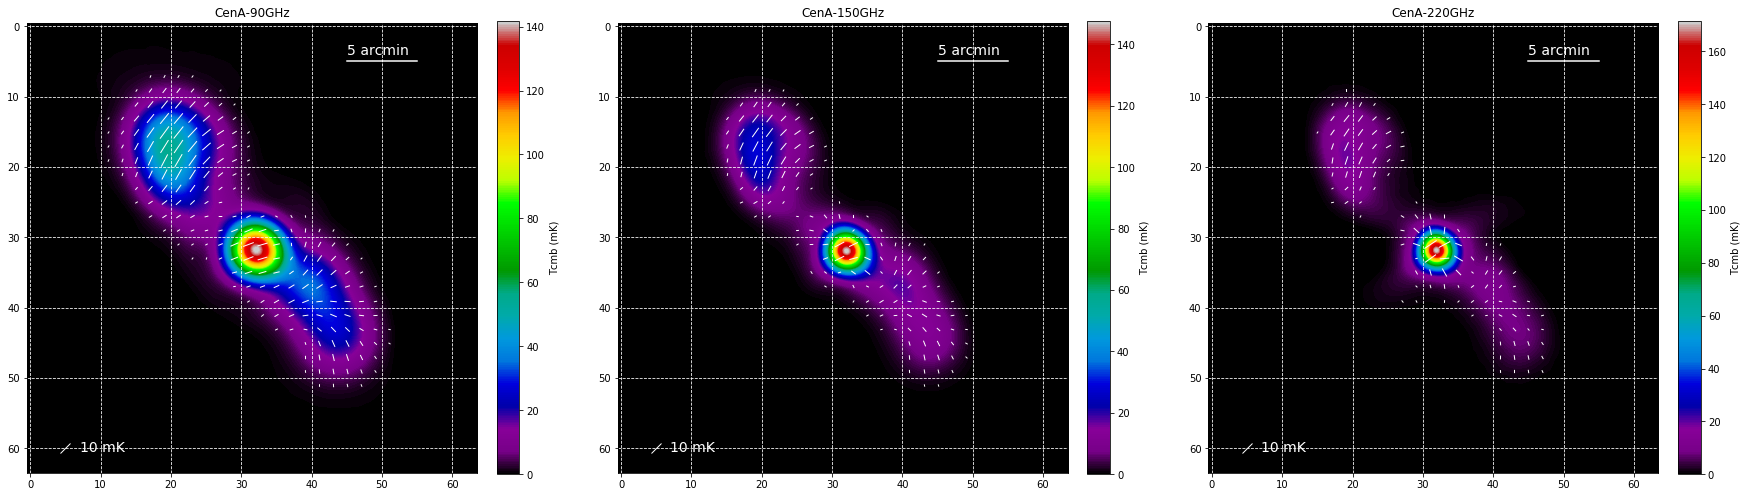

In [6]:
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
res = obsmap.res
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(8/res)
    print(imsize)
    datsize = np.shape(Coadd[band]['T'])[0]//2
    print(datsize)
    T = np.asarray(Coadd[band]['T'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    T[T<.1]=0.
    pl.imshow(T,cmap='nipy_spectral',interpolation='spline16')#,vmin=1,vmax=60)
    pl.colorbar(fraction=.046,pad=.04,label='Tcmb (mK)')
    Q = np.nan_to_num(np.asarray(Coadd[band]['Q'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    U = np.nan_to_num(np.asarray(Coadd[band]['U'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    ang = (np.arctan2(U,Q)-np.pi)/2.
    amp = np.sqrt(Q**2+U**2)
    maxamp = np.amax(amp)
    
    print(band+' MaxPolAmp: %i mK'%maxamp)
    xlen = np.shape(ang)[0]
    for i in range(1,xlen-1,2):
        for j in range(1,xlen-1,2):
            if amp[i,j]>.25 and T[i,j]>1.:
                pl.scatter(j,i,marker=(2,0,np.rad2deg(ang[i,j])),c='w',s=20*amp[i,j])
    pl.title(band)
    #pl.xticks([])
    #pl.yticks([])
    pl.grid(color='w',ls='--')
    #if band == 'CenA-90GHz':
    theta = np.linspace(-np.pi,np.pi,361)
    r = 1.5/res
    #pl.plot(imsize+r*np.cos(theta),imsize+r*np.sin(theta),color='w')
    pl.plot([45,55],[5,5],color='w')
    pl.text(45,4,'5 arcmin',color='w',fontsize=14)
    pl.scatter(5,60,marker=(2,0,-45),c='w',s=200)
    pl.text(7,60.5,'10 mK',color='w',fontsize=14)
    
pl.show()


In [5]:
## Plotting median pixel values and variance on that value
pixmean = {}
pixvars = {}
pixnums = {}
for band in pixelvals:
    pixmean[band] = np.zeros(len(pixelvals[band].keys()))
    pixvars[band] = np.zeros(len(pixelvals[band].keys()))
    pixnums[band] = np.zeros(len(pixelvals[band].keys()))
    for pix in pixelvals[band]:
        pixmean[band][pix] = np.nanmean(pixelvals[band][pix])
        pixvars[band][pix] = np.nanvar(pixelvals[band][pix])
        pixnums[band][pix] = np.count_nonzero(np.isfinite(pixelvals[band][pix]))




40
40
40
40
40
40


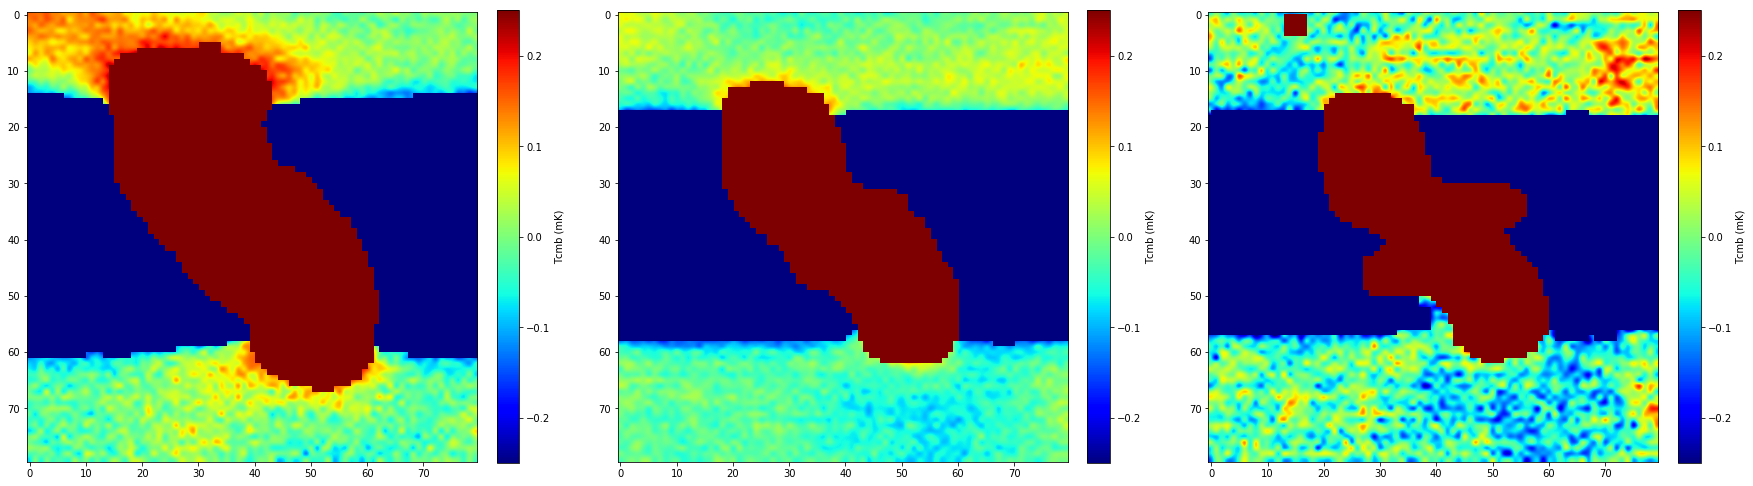

In [6]:
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(10/res)
    print(imsize)
    datsize = np.shape(Coadd[band]['T'])[0]//2
    print(datsize)
    T = np.asarray(Coadd[band]['T'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    
    pl.imshow(T,cmap='jet',interpolation='spline16',vmin=-.25,vmax=.25)#,vmin=1,vmax=60)
    pl.colorbar(fraction=.046,pad=.04,label='Tcmb (mK)')
   
    
pl.show()


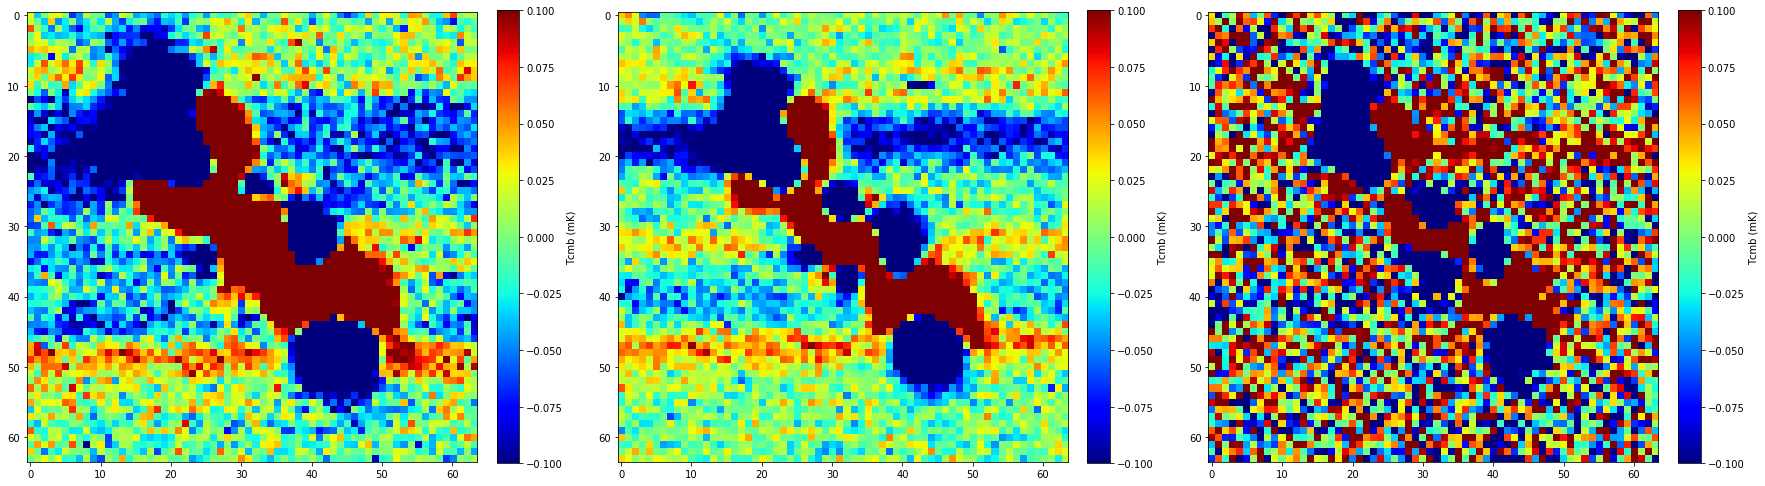

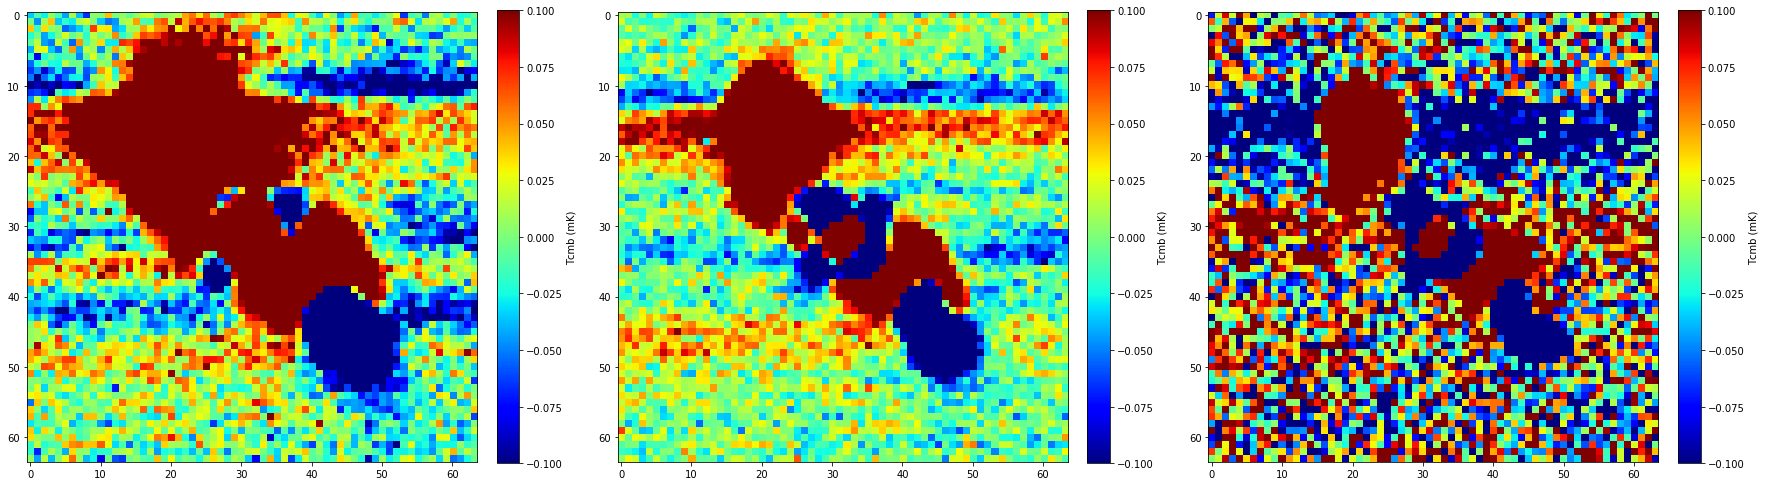

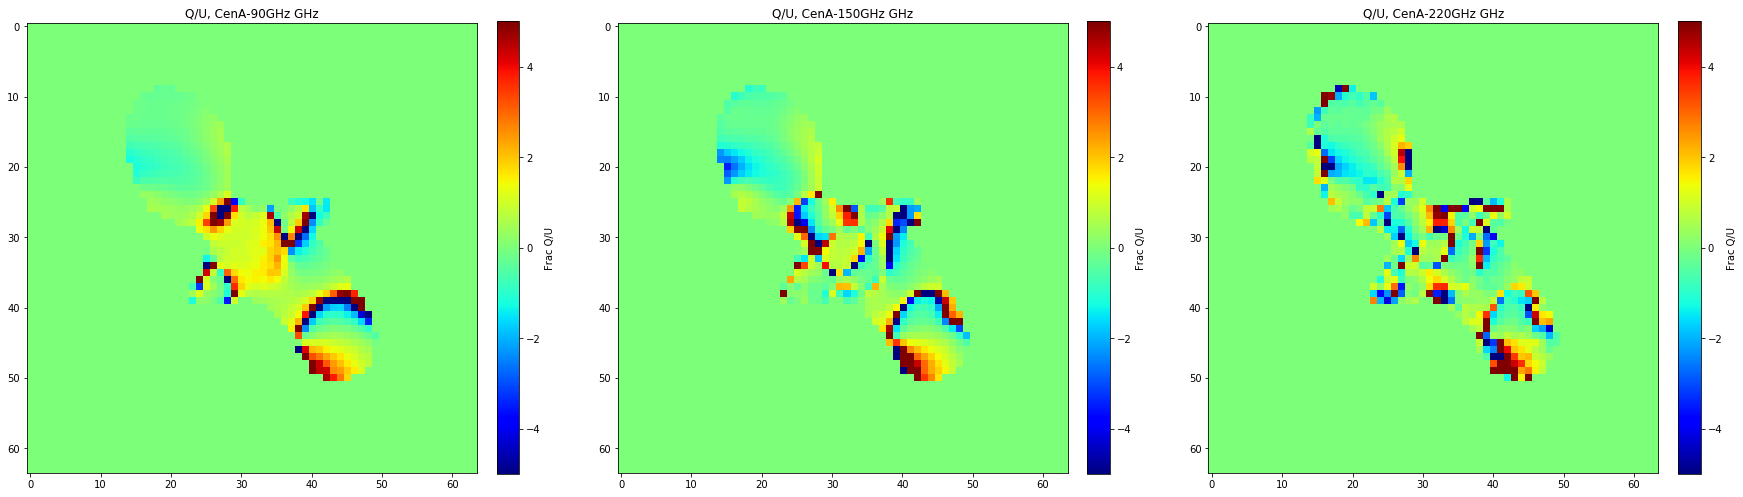

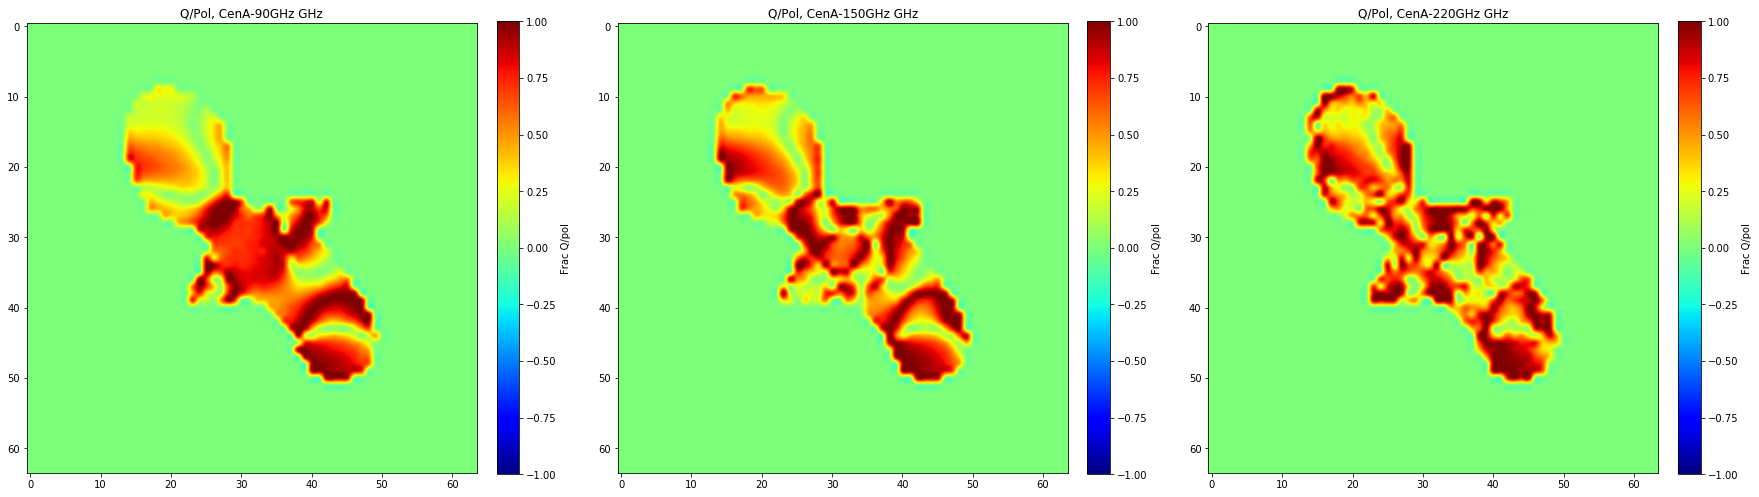

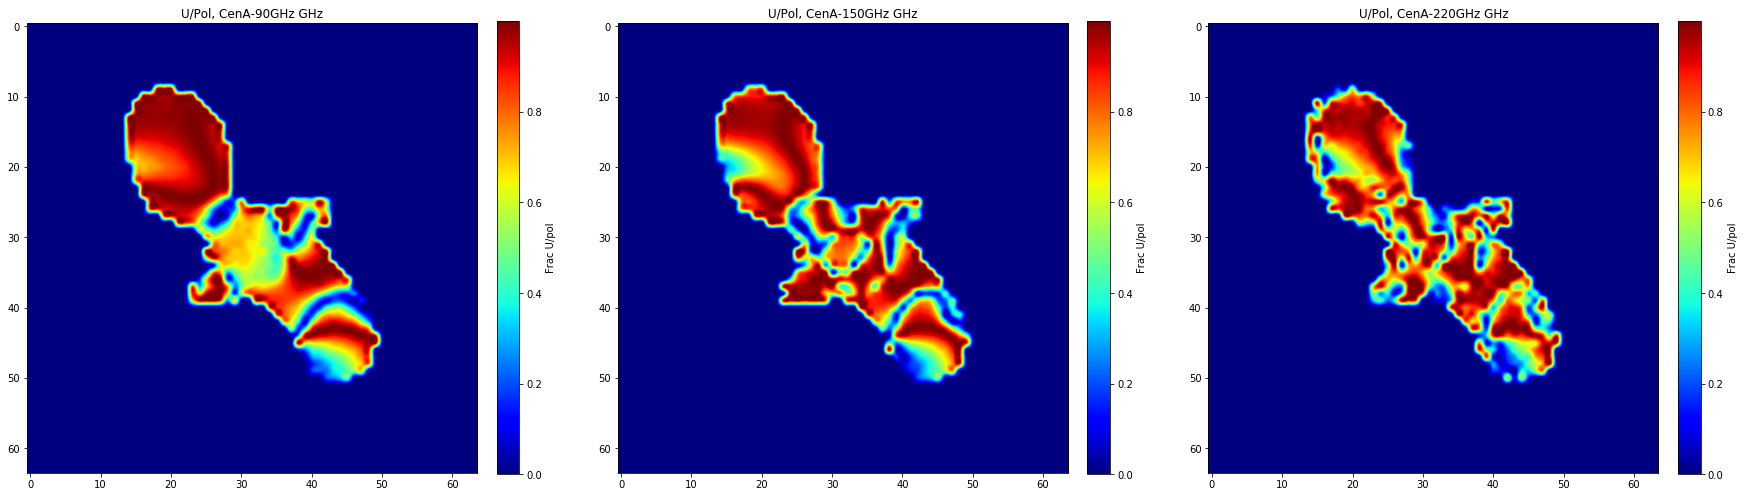

In [29]:
## Plot Q signal
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
Q = {}
U = {}
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(8/res)
    datsize = np.shape(Coadd[band]['Q'])[0]//2
    
    Q[band] = np.asarray(Coadd[band]['Q'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    #Q[T<1]=0.
    pl.imshow(Q[band],cmap='jet',interpolation='none',vmin=-.1,vmax=.1)
    pl.colorbar(fraction=.046,pad=.04,label='Tcmb (mK)')
    
pl.show()

## Plot U signal
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(8/res)
    
    datsize = np.shape(Coadd[band]['U'])[0]//2
    
    U[band] = np.asarray(Coadd[band]['U'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    #U[T<1]=0.
    pl.imshow(U[band],cmap='jet',interpolation='none',vmin=-.1,vmax=.1)
    pl.colorbar(fraction=.046,pad=.04,label='Tcmb (mK)')
    
pl.show()


## Q / U
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    pl.title('Q/U, %s GHz'%band)
    frac = np.copy(Q[band])/np.copy(U[band])
    frac[T<1] = 0
    pl.imshow(frac,cmap='jet',interpolation='none',vmin=-5,vmax=5)
    pl.colorbar(fraction=.046,pad=.04,label='Frac Q/U')
pl.show()

## Fraction of Pol in Q,U
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    pl.title('Q/Pol, %s GHz'%band)
    frac = abs(np.copy(Q[band])/np.sqrt(np.copy(Q[band])**2+np.copy(U[band])**2))
    frac[T<1] = 0
    pl.imshow(frac,cmap='jet',interpolation='spline16',vmin=-1,vmax=1)
    pl.colorbar(fraction=.046,pad=.04,label='Frac Q/pol')
    

pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    pl.title('U/Pol, %s GHz'%band)
    frac = abs(U[band]/np.sqrt(Q[band]**2+U[band]**2))
    frac[T<1] = 0
    pl.imshow(frac,cmap='jet',interpolation='spline16')#,vmin=1,vmax=60)
    pl.colorbar(fraction=.046,pad=.04,label='Frac U/pol')
    
pl.show()

32
40
[   5.   50.   75.  100.]
CenA-90GHz MaxPolAmp: 12 mK
32
40
[   5.   50.   75.  100.]
CenA-150GHz MaxPolAmp: 6 mK
32
40
[   5.   50.   75.  100.]
CenA-220GHz MaxPolAmp: 15 mK


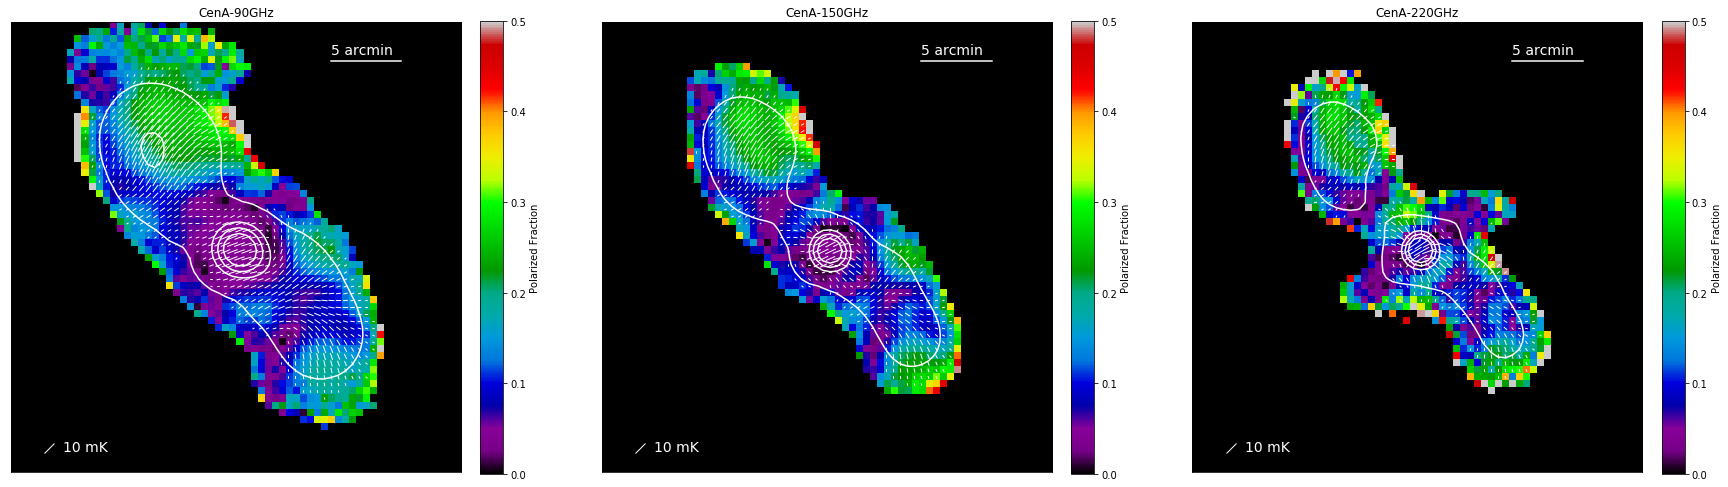

In [25]:
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(8/res)
    print(imsize)
    datsize = np.shape(Coadd[band]['T'])[0]//2
    print(datsize)
    T = np.asarray(Coadd[band]['T'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    #pl.imshow(T,cmap='nipy_spectral',interpolation='spline16')#,vmin=1,vmax=60)
    Q = np.nan_to_num(np.asarray(Coadd[band]['Q'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    U = np.nan_to_num(np.asarray(Coadd[band]['U'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    ang = (np.arctan2(U,Q)-np.pi)/2.
    amp = np.sqrt(Q**2+U**2)
    frac = abs(amp/T)
    frac[T<.25] = 0.
    smoothedfrac = frac #gf(frac, .5/res, order=0,  mode='reflect', cval=0.0, truncate=3.0)
    x = np.arange(np.shape(T)[0])
    y = np.arange(np.shape(T)[1])
    levels = np.array([5.,50.,75.,100.])
    print(levels)
    cset = pl.contour(x,y,T,levels,colors='w')
    #pl.clabel(cset, levels,fmt='%i',fontsize=12)
    pl.imshow(smoothedfrac,cmap='nipy_spectral',interpolation='none',vmin=0,vmax=.50)
    pl.colorbar(fraction=.046,pad=.04,label='Polarized Fraction')
    
    maxamp = np.amax(amp)
    print(band+' MaxPolAmp: %i mK'%maxamp)
    xlen = np.shape(ang)[0]
    for i in range(1,xlen-1,1):
        for j in range(1,xlen-1,1):
            if amp[i,j]>.25 and T[i,j]>1.:
                pl.scatter(j,i,marker=(2,0,np.rad2deg(ang[i,j])),c='w',s=20*amp[i,j])
                pl.title(band)
                pl.xticks([])
                pl.yticks([])
    #if band == 'CenA-90GHz':
    pl.plot([45,55],[5,5],color='w')
    pl.text(45,4,'5 arcmin',color='w',fontsize=14)
    pl.scatter(5,60,marker=(2,0,-45),c='w',s=200)
    pl.text(7,60.5,'10 mK',color='w',fontsize=14)
pl.show()

40
40
[   5.   50.   75.  100.]
CenA-90GHz MaxPolAmp: 12 mK
40
40
[   5.   50.   75.  100.]
CenA-150GHz MaxPolAmp: 6 mK
40
40
[   5.   50.   75.  100.]
CenA-220GHz MaxPolAmp: 15 mK


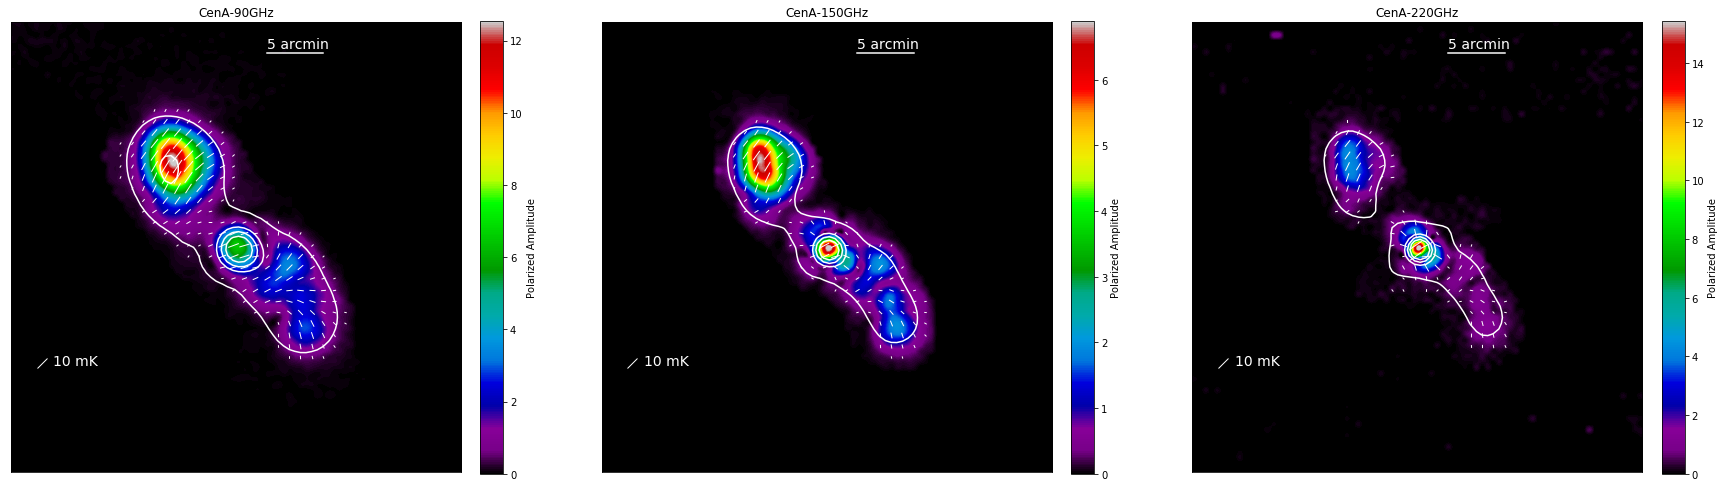

In [17]:
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(8/res)
    print(imsize)
    datsize = np.shape(Coadd[band]['T'])[0]//2
    print(datsize)
    T = np.asarray(Coadd[band]['T'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    #pl.imshow(T,cmap='nipy_spectral',interpolation='spline16')#,vmin=1,vmax=60)
    Q = np.nan_to_num(np.asarray(Coadd[band]['Q'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    U = np.nan_to_num(np.asarray(Coadd[band]['U'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    ang = (np.arctan2(U,Q)-np.pi)/2.
    amp = np.sqrt(Q**2+U**2)
    amp[T<.1] = 0.
    #smoothedfrac = gf(amp, .5/res, order=0,  mode='reflect', cval=0.0, truncate=3.0)
    x = np.arange(np.shape(T)[0])
    y = np.arange(np.shape(T)[1])
    levels = np.array([5.,50.,75.,100.])
    print(levels)
    cset = pl.contour(x,y,T,levels,colors='w')
    #pl.clabel(cset, levels,fmt='%i',fontsize=12)
    pl.imshow(amp,cmap='nipy_spectral',interpolation='spline16')
    pl.colorbar(fraction=.046,pad=.04,label='Polarized Amplitude')
    
    maxamp = np.amax(amp)
    print(band+' MaxPolAmp: %i mK'%maxamp)
    xlen = np.shape(ang)[0]
    for i in range(1,xlen-1,2):
        for j in range(1,xlen-1,2):
            if amp[i,j]>.25 and T[i,j]>1.:
                pl.scatter(j,i,marker=(2,0,np.rad2deg(ang[i,j])),c='w',s=20*amp[i,j])
                pl.title(band)
                pl.xticks([])
                pl.yticks([])
    #if band == 'CenA-90GHz':
    pl.plot([45,55],[5,5],color='w')
    pl.text(45,4,'5 arcmin',color='w',fontsize=14)
    pl.scatter(5,60,marker=(2,0,-45),c='w',s=200)
    pl.text(7,60.5,'10 mK',color='w',fontsize=14)
pl.show()

40
40
[   5.   50.   75.  100.]
40
40
[   5.   50.   75.  100.]
40
40
[   5.   50.   75.  100.]


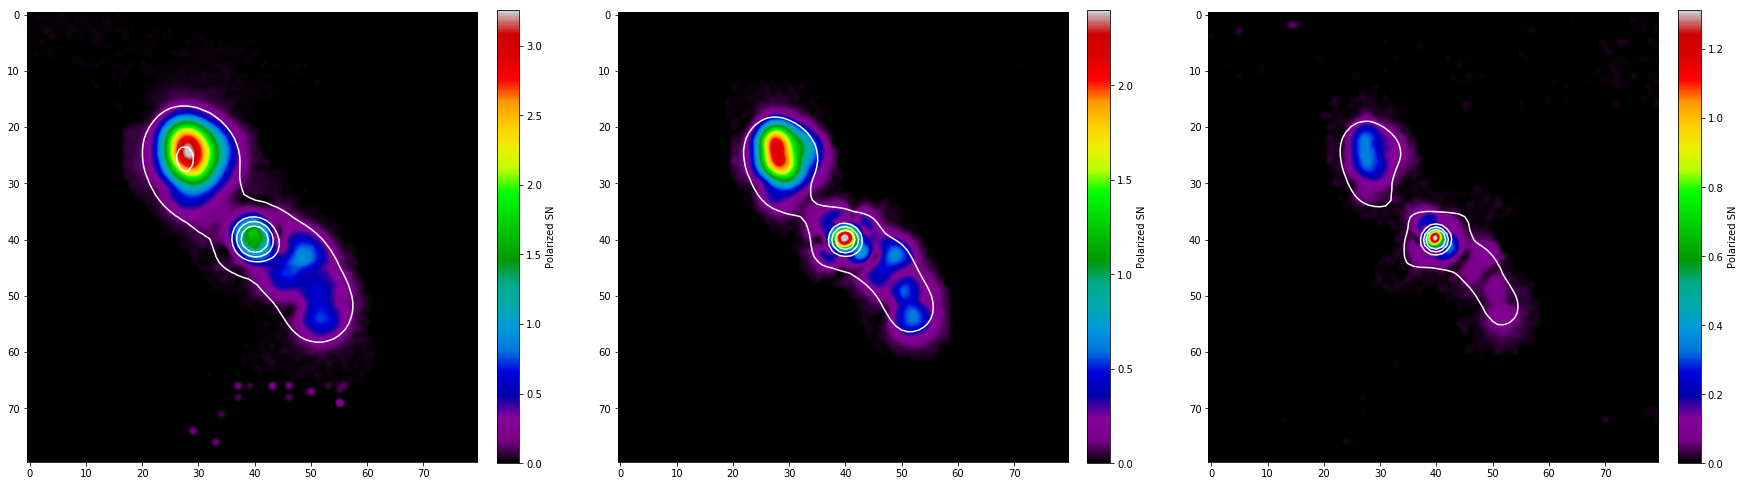

In [19]:
NOISE_MEAN= {'90':3.4,'150':2.6,'220':10.6}

pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(10/res)
    print(imsize)
    datsize = np.shape(Coadd[band]['T'])[0]//2
    print(datsize)
    T = np.asarray(Coadd[band]['T'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    #pl.imshow(T,cmap='nipy_spectral',interpolation='spline16')#,vmin=1,vmax=60)
    Q = np.nan_to_num(np.asarray(Coadd[band]['Q'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    U = np.nan_to_num(np.asarray(Coadd[band]['U'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    ang = (np.arctan2(U,Q)-np.pi)/2.
    amp = np.sqrt(Q**2+U**2)
    amp[T<.1] = 0.
    #smoothedfrac = gf(amp, .5/res, order=0,  mode='reflect', cval=0.0, truncate=3.0)
    x = np.arange(np.shape(T)[0])
    y = np.arange(np.shape(T)[1])
    levels = np.array([5.,50.,75.,100.])
    print(levels)
    cset = pl.contour(x,y,T,levels,colors='w')
    #pl.clabel(cset, levels,fmt='%i',fontsize=12)
    pl.imshow(amp/NOISE_MEAN[band.split('-')[1].split('G')[0]],cmap='nipy_spectral',interpolation='spline16')
    pl.colorbar(fraction=.046,pad=.04,label='Polarized SN')
    '''
    maxamp = np.amax(amp)
    print(band+' MaxPolAmp: %i mK'%maxamp)
    xlen = np.shape(ang)[0]
    for i in range(1,xlen-1,2):
        for j in range(1,xlen-1,2):
            if amp[i,j]>.25 and T[i,j]>1.:
                pl.scatter(j,i,marker=(2,0,np.rad2deg(ang[i,j])),c='w',s=20*amp[i,j])
                pl.title(band)
                pl.xticks([])
                pl.yticks([])
    #if band == 'CenA-90GHz':
    pl.plot([45,55],[5,5],color='w')
    pl.text(45,4,'5 arcmin',color='w',fontsize=14)
    pl.scatter(5,60,marker=(2,0,-45),c='w',s=200)
    pl.text(7,60.5,'10 mK',color='w',fontsize=14)
    '''
pl.show()

(array([32]), array([32]))
CenA-90GHz MaxPolAmp: 11 mK
Average Nucleus Polarization Angle: -68.8306239658 deg
(array([32]), array([32]))
CenA-150GHz MaxPolAmp: 6 mK
Average Nucleus Polarization Angle: -66.9173272365 deg
(array([32]), array([32]))
CenA-220GHz MaxPolAmp: 13 mK
Average Nucleus Polarization Angle: -64.0782157555 deg


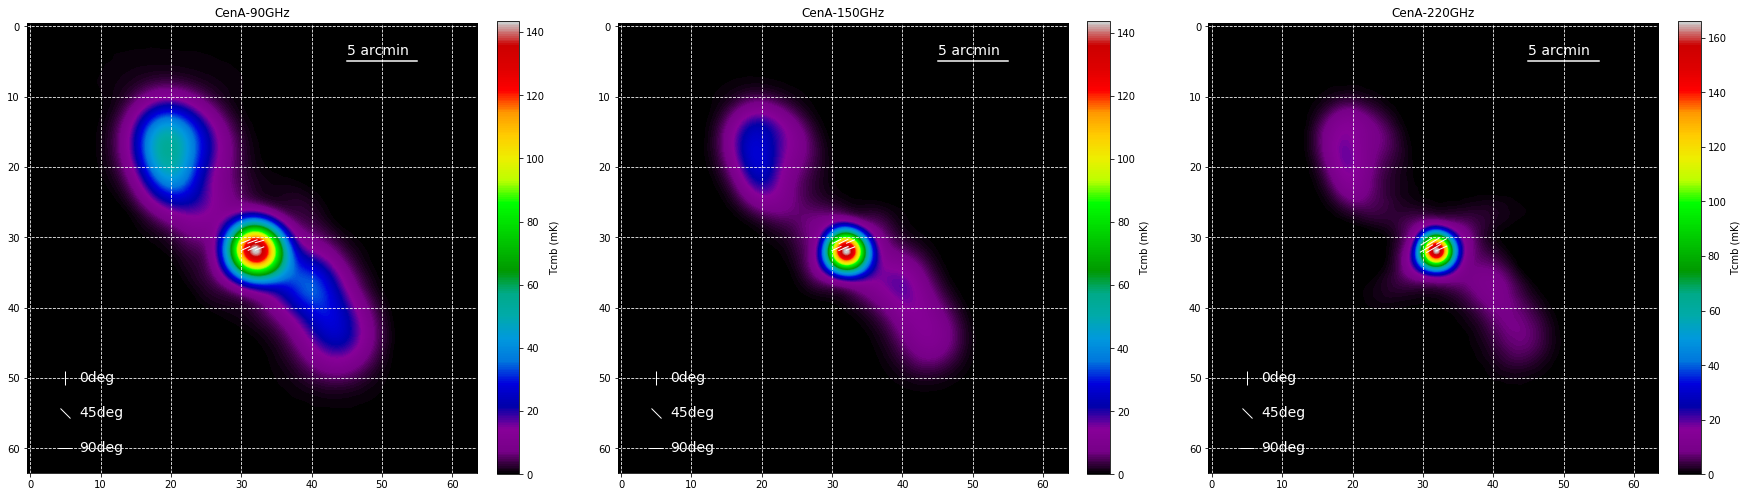

In [12]:
## Nuclear Rotation Measure
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
avgangs = {}
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(8/res)
    #print(imsize)
    datsize = np.shape(Coadd[band]['T'])[0]//2
    #print(datsize)
    T = np.asarray(Coadd[band]['T'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    T[T<.1]=0.
    print(np.where(T == np.amax(T)))
    pl.imshow(T,cmap='nipy_spectral',interpolation='spline16')#,vmin=1,vmax=60)
    pl.colorbar(fraction=.046,pad=.04,label='Tcmb (mK)')
    Q = np.nan_to_num(np.asarray(Coadd[band]['Q'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    U = np.nan_to_num(np.asarray(Coadd[band]['U'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    ang = (np.arctan2(U,Q)-np.pi)/2.
    amp = np.sqrt(Q**2+U**2)
    maxamp = np.amax(amp)
    
    print(band+' MaxPolAmp: %i mK'%maxamp)
    xlen = np.shape(ang)[0]
    dpix = 1
    for i in range(1,xlen-1,dpix):
        for j in range(1,xlen-1,dpix):
            if amp[i,j]>.25 and T[i,j]>1.:
                if i> 30 and i< 33 and j>30 and j<34:
                    pl.scatter(j-dpix/2.,i-dpix/2.,marker=(2,0,np.rad2deg(ang[i,j])),c='w',s=20*amp[i,j])
                pl.title(band)
                #pl.xticks([])
                #pl.yticks([])
    #if band == 'CenA-90GHz':
    #print(ang[30:33,30:34])
    avgang = np.mean(np.rad2deg(ang[30:33,30:34]))
    avgangs[float(band.split('-')[1].split('G')[0])] = avgang
    print('Average Nucleus Polarization Angle: %s deg'%avgang )
    pl.plot([45,55],[5,5],color='w')
    pl.text(45,4,'5 arcmin',color='w',fontsize=14)
    pl.scatter(5,60,marker=(2,0,90),c='w',s=200)
    pl.text(7,60.5,'90deg',color='w',fontsize=14)
    pl.scatter(5,55,marker=(2,0,45),c='w',s=200)
    pl.text(7,55.5,'45deg',color='w',fontsize=14)
    pl.scatter(5,50,marker=(2,0,0),c='w',s=200)
    pl.text(7,50.5,'0deg',color='w',fontsize=14)
    pl.grid(color='w',ls='--')
pl.show()

{90.0: -68.830623965804605, 150.0: -66.917327236454383, 220.0: -64.078215755465266}
{90.0: -108118.89129648662, 150.0: -291981.92172765179, 220.0: -601437.67596478714}
-7893.21196407 rad/m^2


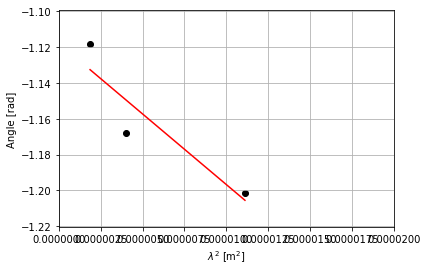

In [13]:
print(avgangs)
RM = {}
w = []
a = []
for band in avgangs:
    wavelength = 3e8/(band*1e9)
    w.append(wavelength**2)
    a.append(np.deg2rad(avgangs[band]))
    RM[band] = np.deg2rad(avgangs[band])/(wavelength)**2
print(RM)
pl.figure()
pl.scatter(w,a,c='k')
fit = np.poly1d(np.polyfit(w,a,1))
print(fit[1],'rad/m^2')
pl.plot(w,fit(w),color='r')
pl.grid()
pl.xlim([0,.00002])
pl.xlabel(r'$\lambda^2$ [m$^2$]')
pl.ylabel('Angle [rad]')
pl.show()

(array([32]), array([32]))
CenA-90GHz MaxPolAmp: 11 mK
Average Nucleus Polarization Angle: -32.551057932 deg
(array([32]), array([32]))
CenA-150GHz MaxPolAmp: 6 mK
Average Nucleus Polarization Angle: -28.5339821076 deg
(array([32]), array([32]))
CenA-220GHz MaxPolAmp: 13 mK
Average Nucleus Polarization Angle: -26.8895204136 deg


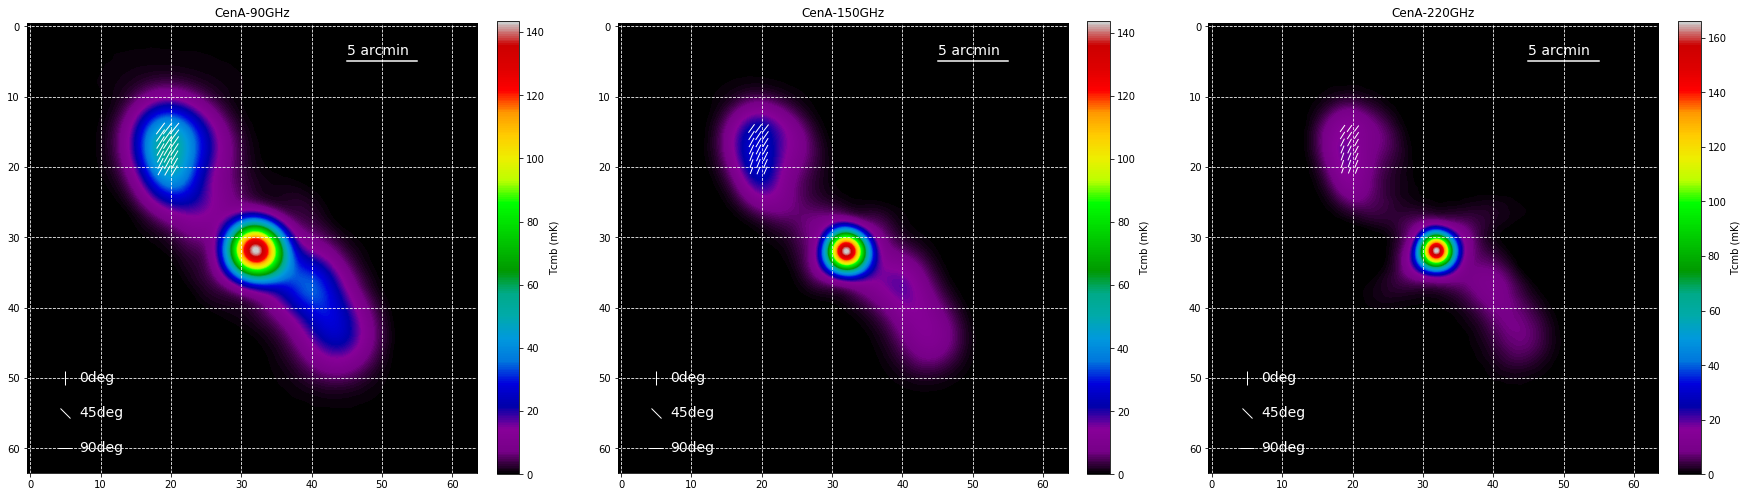

In [14]:
## Upper Lobe Rotation Measure
pl.close('all')
pl.figure(figsize=(30,10))
bandfig = 1
bands = Coadd.keys()
avgangs = {}
for band in bands:
    pl.subplot(1,3,bandfig)
    bandfig+=1
    imsize=int(8/res)
    #print(imsize)
    datsize = np.shape(Coadd[band]['T'])[0]//2
    #print(datsize)
    T = np.asarray(Coadd[band]['T'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize]/Weight[band]
    T[T<.1]=0.
    print(np.where(T == np.amax(T)))
    pl.imshow(T,cmap='nipy_spectral',interpolation='spline16')#,vmin=1,vmax=60)
    pl.colorbar(fraction=.046,pad=.04,label='Tcmb (mK)')
    Q = np.nan_to_num(np.asarray(Coadd[band]['Q'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    U = np.nan_to_num(np.asarray(Coadd[band]['U'])[datsize-imsize:datsize+imsize,datsize-imsize:datsize+imsize])/Weight[band]
    ang = (np.arctan2(U,Q)-np.pi)/2.
    amp = np.sqrt(Q**2+U**2)
    maxamp = np.amax(amp)
    
    print(band+' MaxPolAmp: %i mK'%maxamp)
    xlen = np.shape(ang)[0]
    dpix = 1
    for i in range(1,xlen-1,dpix):
        for j in range(1,xlen-1,dpix):
            if amp[i,j]>.25 and T[i,j]>1.:
                if i> 14 and i< 22 and j>18 and j<22:
                    pl.scatter(j-dpix/2.,i-dpix/2.,marker=(2,0,np.rad2deg(ang[i,j])),c='w',s=20*amp[i,j])
                pl.title(band)
                #pl.xticks([])
                #pl.yticks([])
    #if band == 'CenA-90GHz':
    #print(ang[30:33,30:34])
    avgang = np.mean(np.rad2deg(ang[14:22,18:22]))
    avgangs[float(band.split('-')[1].split('G')[0])] = avgang

    print('Average Nucleus Polarization Angle: %s deg'%avgang )
    pl.plot([45,55],[5,5],color='w')
    pl.text(45,4,'5 arcmin',color='w',fontsize=14)
    pl.scatter(5,60,marker=(2,0,90),c='w',s=200)
    pl.text(7,60.5,'90deg',color='w',fontsize=14)
    pl.scatter(5,55,marker=(2,0,45),c='w',s=200)
    pl.text(7,55.5,'45deg',color='w',fontsize=14)
    pl.scatter(5,50,marker=(2,0,0),c='w',s=200)
    pl.text(7,50.5,'0deg',color='w',fontsize=14)
    pl.grid(color='w',ls='--')
pl.show()

{90.0: -32.551057932011588, 150.0: -28.533982107560693, 220.0: -26.889520413570771}
{90.0: -51131.082232891677, 150.0: -124502.98412052121, 220.0: -252384.84677948224}
-10474.3369849 rad/m^2


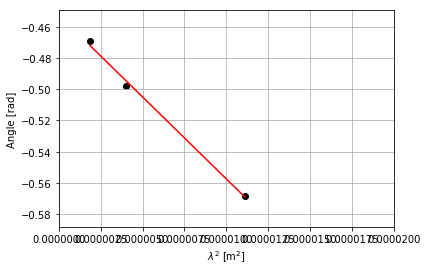

In [15]:
print(avgangs)
RM = {}
w = []
a = []
for band in avgangs:
    wavelength = 3e8/(band*1e9)
    w.append(wavelength**2)
    a.append(np.deg2rad(avgangs[band]))
    RM[band] = np.deg2rad(avgangs[band])/(wavelength)**2
print(RM)
pl.figure()
pl.scatter(w,a,c='k')
fit = np.poly1d(np.polyfit(w,a,1))
print(fit[1],'rad/m^2')
pl.plot(w,fit(w),color='r')
pl.grid()
pl.xlim([0,.00002])
pl.xlabel(r'$\lambda^2$ [m$^2$]')
pl.ylabel('Angle [rad]')
pl.show()